# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
#pip install keras-flops

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import matplotlib.pyplot as plt
from keras_flops import get_flops
tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

/Users/zoe/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Data loading

In [2]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

2022-10-27 11:55:27.664264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Model creation

In [3]:
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
#The shape of MNIST is 28*28*1
cnn_model.add(tf.keras.Input(shape = (28,28,1)))
cnn_model.add(tf.keras.layers.Conv2D(32, 3, strides = 1, activation = 'relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides = 1))
cnn_model.add(tf.keras.layers.Conv2D(64, 3, strides=1, activation = 'relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides = 2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(128,activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(10))

# Build fully connected student.
fc_model = tf.keras.Sequential()


# your code start from here for step 2
fc_model.add(tf.keras.Input(shape=(28,28,1)))
fc_model.add(tf.keras.layers.Flatten())
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(10))



In [4]:
cnn_model.summary()
fc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dropout (Dropout)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               9

# Teacher loss function

In [5]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits)
  )


  return cross_entropy_loss_value

# Student loss function

In [6]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4 #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  #https://medium.com/analytics-vidhya/knowledge-distillation-in-a-deep-neural-network-c9dd59aff89b
  student_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))
  cross_entropy_loss_value = ALPHA * student_loss + (1-ALPHA) * distillation_loss_value

  return cross_entropy_loss_value

# Train and evaluation

In [7]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  #as specified in the assignment, optimizer is Adam, learning rate is 0.001 for all models
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      val1, val2, val3 = compute_num_correct(model,images,labels)
      num_correct += val1
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))


# Training models

In [8]:
# your code start from here for step 5 

print("Teacher Model")
#train and evaluate the teacher model
train_and_evaluate(cnn_model, compute_teacher_loss)

print("Student Model")
#train and evaluate the student model
train_and_evaluate(fc_model, compute_student_loss)

2022-10-27 11:55:27.821708: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Teacher Model
Epoch 1: Class_accuracy: 98.04%
Epoch 2: 

KeyboardInterrupt: 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: [<tf.Tensor: shape=(), dtype=float32, numpy=96.73>, <tf.Tensor: shape=(), dtype=float32, numpy=97.39>, <tf.Tensor: shape=(), dtype=float32, numpy=97.64>, <tf.Tensor: shape=(), dtype=float32, numpy=97.67>, <tf.Tensor: shape=(), dtype=float32, numpy=97.71>, <tf.Tensor: shape=(), dtype=float32, numpy=97.81>, <tf.Tensor: shape=(), dtype=float32, numpy=97.78>, <tf.Tensor: shape=(), dtype=float32, numpy=97.93>, <tf.Tensor: shape=(), dtype=float32, numpy=97.88>, <tf.Tensor: shape=(), dtype=float32, numpy=97.86>, <tf.Tensor: shape=(), dtype=float32, numpy=97.93>, <tf.Tensor: shape=(), dtype=float32, numpy=97.939995>]
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: [<tf.Tensor: shape=(), dtype=float32, n

Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: [<tf.Tensor: shape=(), dtype=float32, numpy=98.439995>, <tf.Tensor: shape=(), dtype=float32, numpy=98.39>, <tf.Tensor: shape=(), dtype=float32, numpy=98.31>, <tf.Tensor: shape=(), dtype=float32, numpy=98.42>, <tf.Tensor: shape=(), dtype=float32, numpy=98.34>, <tf.Tensor: shape=(), dtype=float32, numpy=98.45>, <tf.Tensor: shape=(), dtype=float32, numpy=98.35>, <tf.Tensor: shape=(), dtype=float32, numpy=98.32>, <tf.Tensor: shape=(), dtype=float32, numpy=98.4>, <tf.Tensor: shape=(), dtype=float32, numpy=98.34>, <tf.Tensor: shape=(), dtype=float32, numpy=98.369995>, <tf.Tensor: shape=(), dtype=float32, numpy=98.35>]
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: [<tf.Tensor: shape=(), dtype=float32, numpy=98.409996>, <tf.Tensor: shape=()

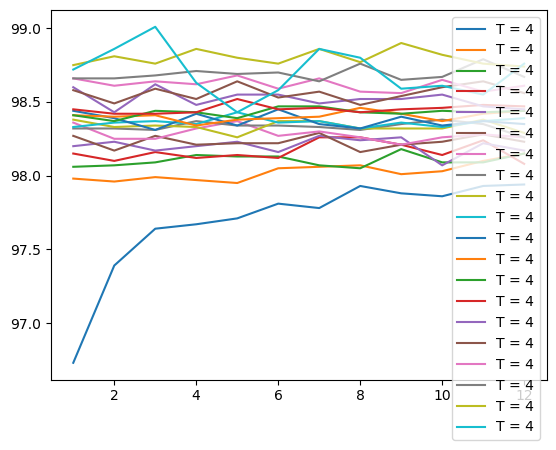

In [9]:
# your code start from here for step 6
#expolre the effect of alpha when T is 4 in order to tune the model
As = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55,0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.0]

epoch = [1,2,3,4,5,6,7,8,9,10,11,12]
T = 4

#Copy from previous
def compute_student_loss_plot(images, labels, a):
    student_subclass_logits = fc_model(images, training = True)
    teacher_subclass_logits = cnn_model(images, training = False)
    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, T)
    student_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits))
    cross_entropy_loss_value = a*student_loss + (1-a) * distillation_loss_value
    
    return cross_entropy_loss_value
    
#copy from the previous
def train_and_plot(model, compute_loss_fn, a):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  #as specified in the assignment, optimizer is Adam, learning rate is 0.001 for all models
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
  result = []
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels, a)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      val1, val2, val3 = compute_num_correct(model,images,labels)
      num_correct += val1
    test_accuracy = num_correct/num_total*100
    result.append(test_accuracy)
  return result
    
print(epoch)
for a in As:
    result = train_and_plot(fc_model,compute_student_loss_plot,a)
    print(result)
    print(tf.shape(epoch))
    print(tf.shape(result))
    test, = plt.plot(epoch, result, label = "T = {}".format(T))
plt.legend()
plt.show()

# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
Ts = [1,2,4,16,32,64]
epoch = [1,2,3,4,5,6,7,8,9,10,11,12]
ALPHA = 0.5

#Copy from previous
def compute_student_loss_plot(images, labels, T):
    student_subclass_logits = fc_model(images, training = True)
    teacher_subclass_logits = cnn_model(images, training = False)
    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, T)
    student_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits))
    cross_entropy_loss_value = ALPHA*student_loss + (1-ALPHA) * distillation_loss_value
    
    return cross_entropy_loss_value
    
#copy from the previous
def train_and_plot(model, compute_loss_fn, T):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  #as specified in the assignment, optimizer is Adam, learning rate is 0.001 for all models
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
  result = []
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels, T)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      val1, val2, val3 = compute_num_correct(model,images,labels)
      num_correct += val1
    test_accuracy = num_correct/num_total*100
    result.append(test_accuracy)
  return result
    
print(epoch)
for T in Ts:
    result = train_and_plot(fc_model,compute_student_loss_plot,T)
    print(result)
    print(tf.shape(epoch))
    print(tf.shape(result))
    test, = plt.plot(epoch, result, label = "T = {}".format(T))
plt.legend()
plt.show()
    

# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(tf.keras.Input(shape=(28,28,1)))
fc_model_no_distillation.add(tf.keras.layers.Flatten())
fc_model_no_distillation.add(tf.keras.layers.Dense(784,activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(784,activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(10))



#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits)
  
  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
# your code start from here for step 8
#number of parameters
print("Teacher Model parameters:")
cnn_model.summary()
print("Student Model parameters:")
fc_model.summary()

#Calculate the FLOPs
#Code Source: https://pypi.org/project/keras-flops/

teacher_flop = get_flops(cnn_model,batch_size = 1)
student_flop = get_flops(fc_model,batch_size = 1)
print(f"Teacher Model FLOPS: {teacher_flop/10**9:.03} G")
print(f"Student Model FLOPS: {student_flop/10**9:0.3} G")

# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 12


# (Optional) XAI method to explain models

In [ ]:
# your code start from here for step 13
